<center><img src="https://i.imgur.com/20rO1id.jpg" width="500px"></center>

# Introduction

In this project called "Prostate cANcer graDe Assessment (PANDA) Challenge", I will a build machine learning model to diagnose Prostate Cancer from biopsy scans (images and masks). This problem is important because fast and accurate automated diagnosis can help reduce burden on doctors and let them focus on curing patients.

I will show how one can build a **multitask model** to solve this problem. I will build a ResNet-based model, which takes a biopsy scan as input and predicts two quantities: the **ISUP grade and  Gleason score**. These are two different, bu related scales used to measure the severity of Prostate Cancer. Training a model on two different, but related tasks **can improve the model's performance on both tasks.


<center><img src="https://i.imgur.com/piOxK6F.png" width="750px"></center>

# Acknowledgements

1. [PyTorch XLA ~ by PyTorch](https://pytorch.org/xla/release/1.5/index.html)
2. [Torchvision Models ~ by PyTorch](https://pytorch.org/docs/stable/torchvision/models.html)
3. [PANDA / submit test ~ Yasufumi Nakama](https://www.kaggle.com/yasufuminakama/panda-submit-test)
4. [Super-duper fast pytorch tpu kernel... ~ by Abhishek](https://www.kaggle.com/abhishek/super-duper-fast-pytorch-tpu-kernel)

# Contents

* [<font size=4>Preparing the ground</font>](#1)
    * [Set up PyTorch-XLA](#1.1)
    * [Import libraries](#1.2)
    * [Set hyperparameters and paths](#1.3)
    * [Load .csv data](#1.4)
    * [Convert Gleason scores to list format](#1.5)
    * [Display few images](#1.6)

    
* [<font size=4>Modeling</font>](#2)
    * [Build PyTorch dataset](#2.1)
    * [Build ResNet model](#2.2)
    * [Visualize ResNet architecture](#2.3)
    * [Split train.csv into 8 folds](#2.4)
    * [Define cross entropy and accuracy](#2.5)
    * [Define custom PANDA loss for multitask model](#2.6)
    * [Define helper function for training logs](#2.7)
    * [Train model on all 8 TPU cores in parallel](#2.8)


* [<font size=4>Takeaways</font>](#3)

# Preparing the ground <a id="1"></a>

## Set up PyTorch-XLA

* These few lines of code sets up PyTorch XLA for us.
* We need PyTorch XLA to help us train PyTorch models on TPU.

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!export XLA_USE_BF16=1
!pip install -q torchviz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0   109k      0 --:--:-- --:--:-- --:--:--  109k
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/91.1 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/120.3 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchv

## Import libraries

* We will import several different packages and libraries required for different parts of the project. For example, we import numpy and pandas for data manipulation and torch and torch_xla for modeling.

In [2]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.io import MultiImage
from joblib import Parallel, delayed

from sklearn.utils import shuffle
from colorama import Fore, Back, Style
from keras.utils import to_categorical as cat

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor as LongTensor
from torch import FloatTensor as FloatTensor

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, densenet121, mobilenet_v2
from albumentations import RandomRotate90, Flip, Compose, Normalize, RandomResizedCrop

Using TensorFlow backend.


In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Set hyperparamerters and paths 

* Here, we define the required hyperparameters such as the training batch size, learning rate, training/validation split percentage, etc.

In [4]:
FOLDS = 8
EPOCHS = 4

RRC = 1.0
FLIP = 1.0
NORM = 1.0
ROTATE = 1.0
LR = (1e-4, 1e-3)
MODEL_SAVE_PATH = "resnet_model"

WIDTH = 512
HEIGHT = 512
BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
DATA_PATH = '../input/prostate-cancer-grade-assessment/'
RESIZED_PATH = '../input/panda-resized-train-data-512x512/train_images/'

In [5]:
TEST_DATA_PATH = DATA_PATH + 'test.csv'
TRAIN_DATA_PATH = DATA_PATH + 'train.csv'
TEST_IMG_PATH = DATA_PATH + 'test_images/'
TRAIN_IMG_PATH = RESIZED_PATH + 'train_images/'
SAMPLE_SUB_PATH = DATA_PATH + 'sample_submission.csv'

## Load .csv data

* We now load the training and tessting data required for the project using the read_csv function from the pandas library.

In [6]:
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRAIN_DATA_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

## Convert Gleason scores to list format

* Next, we convert the Gleason into the proper format which our model needs.

In [7]:
gleason_replace_dict = {0:0, 1:1, 3:2, 4:3, 5:4}

def process_gleason(gleason):
    if gleason == 'negative': gs = (1, 1)
    else: gs = tuple(gleason.split('+'))
    return [gleason_replace_dict[int(g)] for g in gs]

train_df.gleason_score = train_df.gleason_score.apply(process_gleason)

In [8]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,"[0, 0]"
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,"[0, 0]"
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,"[3, 3]"
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,"[3, 3]"
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,"[0, 0]"


In [9]:
test_df.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


## Display few images

* Now we display few sample images from the dataset to get an idea of what they look like.
* In this example, I hve plotted a total of 25 images of biopsy scans in a 5 x 5 grid using matplotlib.

In [10]:
def display_images(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))

    for i in range(int(sq_num)):
        for j in range(int(sq_num)):
            idx = i*sq_num + j
            path = TRAIN_IMG_PATH + train_df.image_id[idx]
    
            path += '.png'
            ax[i, j].imshow(cv2.imread(path))
            ax[i, j].set_title('Image {}'.format(idx), fontsize=12)

    plt.show()

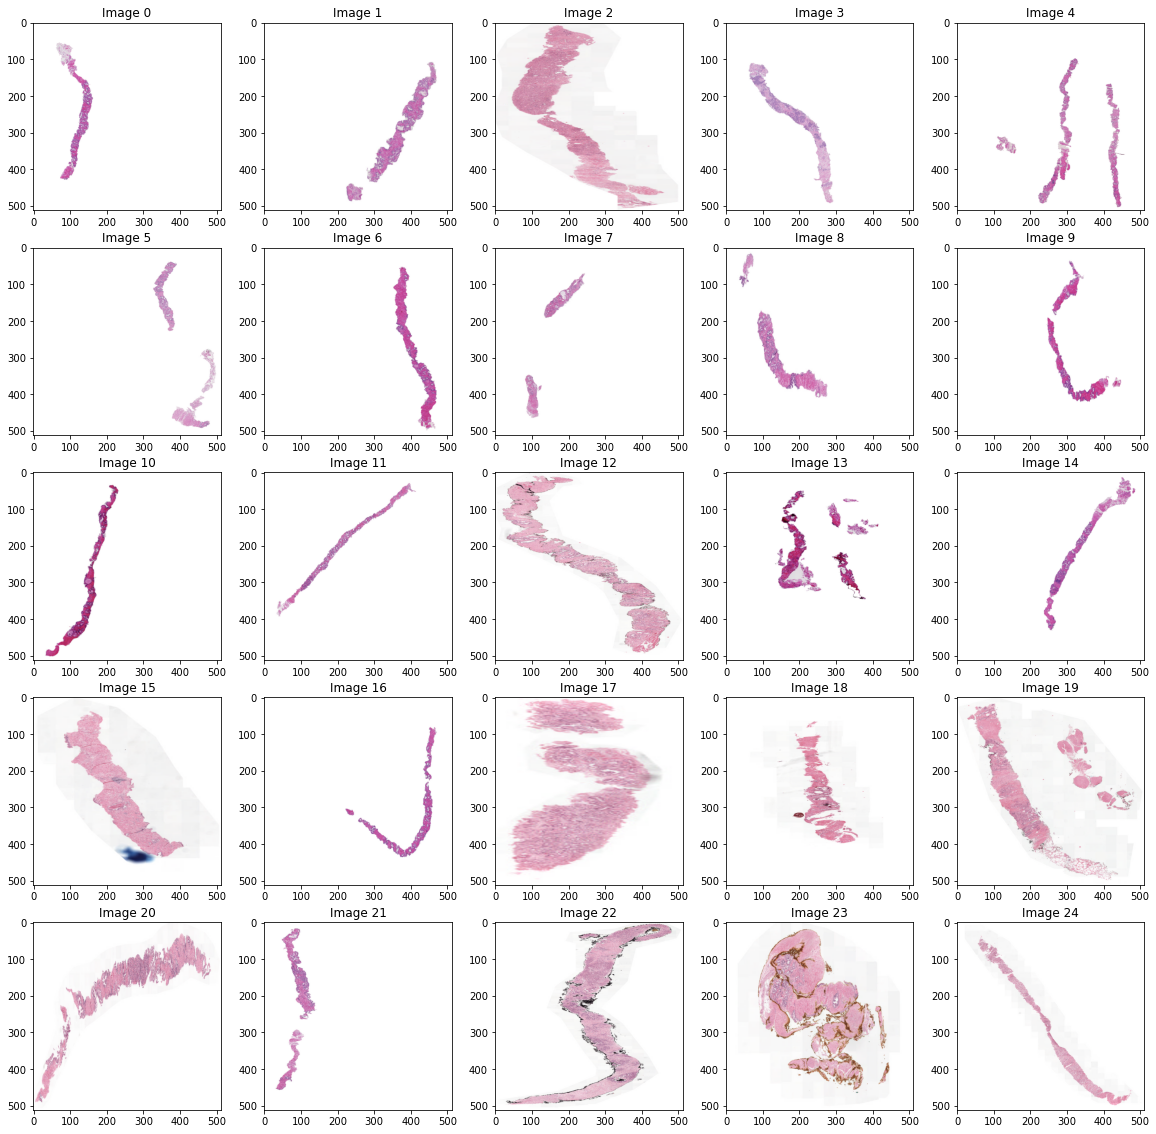

In [11]:
display_images(25)

# Modeling <a id="2"></a>

## Build PyTorch dataset

* Now we define a PyTorch Dataset which will help us feed data to the ResNet model for training and inference.
* We first read images using the OpenCV and skimage python packages, and then normalize and augment the images using albumentations.
* In this example, I have used the rotation and random cropping augmentations, but more augmentations can be used.

In [12]:
class PANDADataset(Dataset):
    def __init__(self, data, img_path, is_val=False, is_train=False):

        self.data = data
        self.is_val = is_val
        self.is_train = is_train
        self.image_path = img_path
        self.image_id = data.image_id
        self.aug = self.norm = Normalize(p=NORM)

        if is_train or is_val:
            self.isup_grade = data.isup_grade
            self.gleason_score = data.gleason_score

            if is_train:
                self.flip = Flip(p=FLIP)
                self.rotate = RandomRotate90(p=ROTATE)
                self.crop = RandomResizedCrop(p=RRC, width=WIDTH, height=HEIGHT)
                self.aug = Compose([self.flip, self.rotate, self.crop, self.norm], p=1)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.image_path + self.image_id[idx]

        if self.is_train or self.is_val:
            path += '.png'
            image = cv2.imread(path)
        else:
            path += '.tiff'
            image = MultiImage(path)[-1]
            image = cv2.resize(image, (HEIGHT, WIDTH))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.aug(image=image)['image'].reshape((3, HEIGHT, WIDTH))
        
        if self.is_train or self.is_val:
            isup_grade = cat([self.data.isup_grade[idx]], num_classes=6)
            gleason_0 = cat([self.data.gleason_score[idx][0]], num_classes=5)
            gleason_1 = cat([self.data.gleason_score[idx][1]], num_classes=5)
            target = np.concatenate([isup_grade, gleason_0, gleason_1], axis=1)
            
        if self.is_train or self.is_val:
            return FloatTensor(image), FloatTensor(target)
        else:
            return FloatTensor(image)

## Build ResNet model

* Now we build a model based on ResNet-18 from the torchvision package to predict the ISUP grade and the Gleason score.
* We first get the ResNet-18 backbone and then add three dense heads on this backbone to classify three quantities (ISUP, G0, G1).

In [13]:
class ResNetDetector(nn.Module):
    def __init__(self):
        super(ResNetDetector, self).__init__()

        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(512, 6)
        self.dense_2 = nn.Linear(512, 5)
        self.dense_3 = nn.Linear(512, 5)
        self.resnet = resnet34(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
    def forward(self, img):
        feat = self.resnet(img).squeeze()

        isup_logit = self.dense_1(feat)
        gleason_logit_0 = self.dense_2(feat)
        gleason_logit_1 = self.dense_3(feat)
        
        isup_prob = self.softmax(isup_logit)
        gleason_prob_0 = self.softmax(gleason_logit_0)
        gleason_prob_1 = self.softmax(gleason_logit_1)
        return torch.cat([isup_prob, gleason_prob_0, gleason_prob_1], axis=1)

## Visualize ResNet architecture

* Below is a visualization of the ResNet-18 architecture using torchviz.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


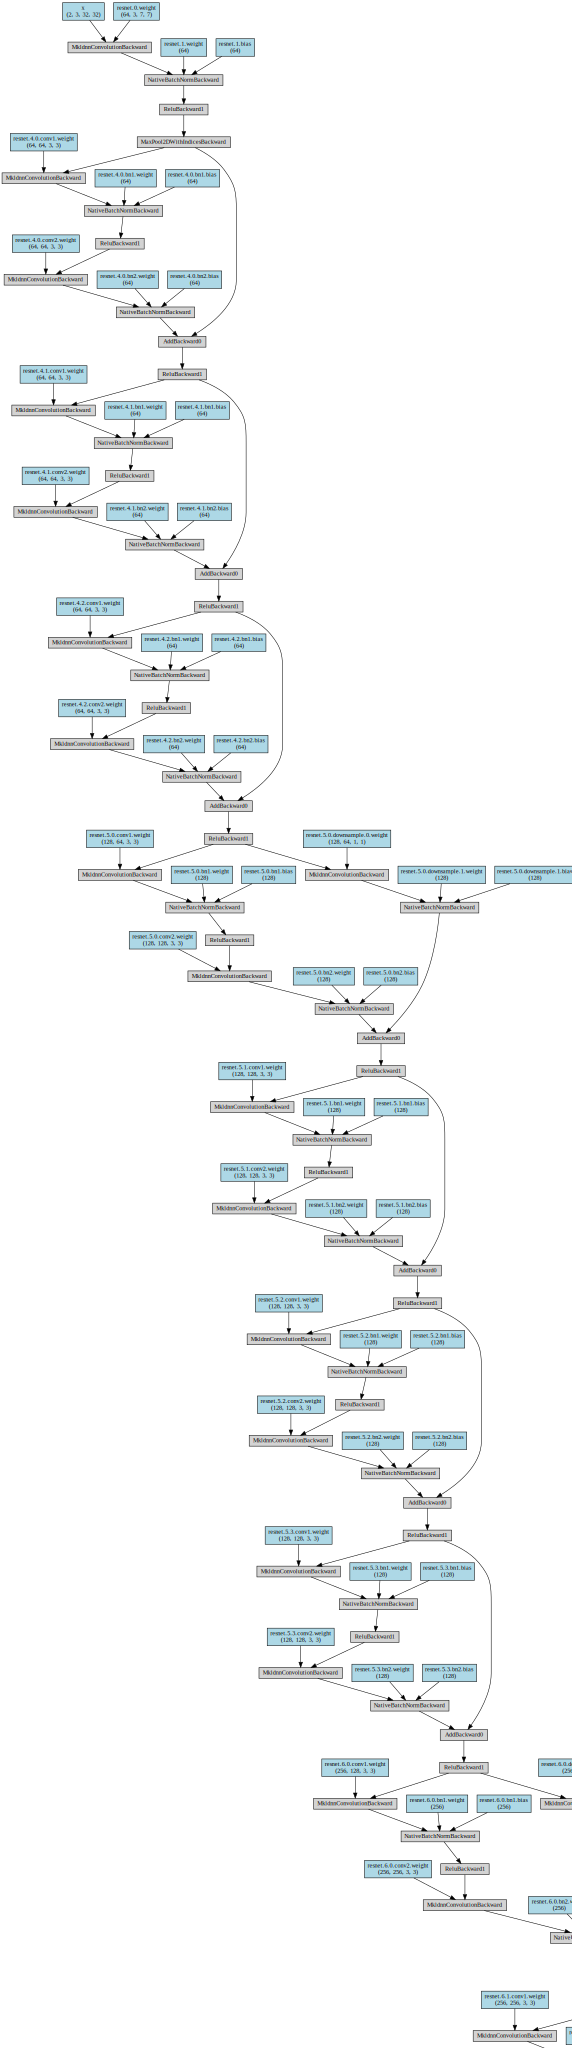

In [14]:
model = ResNetDetector()
x = torch.randn(2, 3, 32, 32).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

In [15]:
del model, x, y
gc.collect()

55305

## Split train.csv into 8 folds

* We now split the data into 8 folds using a simple for loop.

In [16]:
val_sets, train_sets = [], []
val_splits = np.int32((np.arange(FOLDS + 1)/FOLDS) * len(train_df))
val_indices = [[val_splits[i], val_splits[i+1]] for i in range(FOLDS)]

for fold in tqdm(range(FOLDS)):
    val_idx = val_indices[fold]
    if fold == FOLDS - 1: val_idx[1] -= 1
    val_sets.append(train_df[val_idx[0]:val_idx[1]])
    train_sets.append(pd.concat([train_df[:val_idx[0]], train_df[val_idx[1]:]]))

## Define cross entropy and accuracy

* Here we implement categorical cross entropy and accuracy functions in PyTorch.
* CEL is the loss function which is commonly used in classification tasks and helps us finetune ResNet's weights.

In [17]:
def cel(inp, targ):
    _, labels = targ.max(dim=1)
    return nn.CrossEntropyLoss()(inp, labels)

def acc(inp, targ):
    inp_idx = inp.max(axis=1).indices
    targ_idx = targ.max(axis=1).indices
    return (inp_idx == targ_idx).float().sum(axis=0)/len(inp_idx)

## Define custom PANDA loss for multitask model

* Now we define a custom loss function for this problem. We basically calculate the cross entropy for each of the three targets and add them.
* When the model optimizes this new combined CEL function, it will enable the model to learn multiple tasks at the same time (w/ gradients).

In [18]:
def panda_cel(inp, targ):
    isup_loss = cel(inp[:, :6], targ[:, :6])
    gleason_loss_0 = cel(inp[:, 6:11], targ[:, 6:11])
    gleason_loss_1 = cel(inp[:, 11:16], targ[:, 11:16])
    return [isup_loss, gleason_loss_0, gleason_loss_1],\
           isup_loss + gleason_loss_0 + gleason_loss_1

def panda_acc(inp, targ):
    isup_accuracy = acc(inp[:, :6], targ[:, :6])
    gleason_accuracy_0 = acc(inp[:, 6:11], targ[:, 6:11])
    gleason_accuracy_1 = acc(inp[:, 11:16], targ[:, 11:16])
    return np.array([isup_accuracy, gleason_accuracy_0, gleason_accuracy_1])

## Define helper function for training logs

* We now define a simple function to get training logs.

In [19]:
def print_metric(data, fold, start, end, metric, typ):
    r = Fore.RESET
    n = ["ISUP", "G-0", "G-1"]
    time = np.round(end - start, 1)
    time = "Time: {} s".format(time)
    c = [Fore.CYAN, Fore.YELLOW, Fore.MAGENTA]
    
    tick = Fore.GREEN + '\u2714' + Fore.RESET
    prefix = "FOLD {} ".format(fold + 1) + tick + "  "
    
    string = prefix
    for idx in range(3):
        value = np.round(data[idx].detach().cpu().numpy(), 3)
        t = typ, n[idx], metric, c[idx], np.round(value, 3), Fore.RESET
        string = string + "{} {} {}: {}{}{}".format(*t) + "  "
        
    print(string + time)

## Train model on all 8 TPU cores in parallel

* We will now train the model in parallel on all 8 TPU cores.
* In this example, I use the <code>Parallel</code> and <code>delayed</code> functionalities of joblib to run each fold on one TPU core.
* All 8 folds in our training process and therefore running at the same time on each of the 8 TPU cores available to us on Kaggle kernels.

In [20]:
def train(fold):
    val = val_sets[fold]
    train = train_sets[fold]
    device = xm.xla_device(fold + 1)
    
    def xla(tensor):
        return tensor.to(device)
   
    val = val.reset_index(drop=True)
    val_set = PANDADataset(val, TRAIN_IMG_PATH, is_val=True)
    val_loader = DataLoader(val_set, batch_size=VAL_BATCH_SIZE)

    train = train.reset_index(drop=True)
    train_set = PANDADataset(train, TRAIN_IMG_PATH, is_train=True)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    network = xla(ResNetDetector())
    optimizer = Adam([{'params': network.resnet.parameters(), 'lr': LR[0]},
                      {'params': network.dense_1.parameters(), 'lr': LR[1]},
                      {'params': network.dense_2.parameters(), 'lr': LR[1]},
                      {'params': network.dense_3.parameters(), 'lr': LR[1]}])

    start = time.time()
    for epoch in range(EPOCHS):

        batch = 1
        for train_batch in train_loader:
            train_img, train_targs = train_batch

            network = xla(network)
            train_img = xla(train_img)
            train_targs = xla(train_targs)
            
            network.train()
            train_preds = network.forward(train_img)
            train_acc = panda_acc(train_preds, train_targs.squeeze())
            train_loss, total_loss = panda_cel(train_preds, train_targs.squeeze())

            optimizer.zero_grad()
            total_loss.backward()
            xm.optimizer_step(optimizer, barrier=True)

            batch = batch + 1
           
    network.eval()
    val_loss, val_acc = 0, 0
    for val_batch in val_loader:

        img, targ = val_batch
        with torch.no_grad():
            network = xla(network)
            img, targ = xla(img), xla(targ)

            pred = network.forward(img)
            val_acc += panda_acc(pred, targ.squeeze(dim=1))*len(pred)
            val_loss += panda_cel(pred, targ.squeeze(dim=1))[1].item()*len(pred)
       
    end = time.time()
    network = network.cpu()
    val_acc /= len(val_set)
    val_loss /= len(val_set)
    path = MODEL_SAVE_PATH + "_" + str(fold + 1) + ".pt"
    print_metric(val_acc, fold, start, end, metric="acc", typ="Val")
    torch.save(network.state_dict(), path); del network; gc.collect()

In [21]:
Parallel(n_jobs=FOLDS, backend="threading")(delayed(train)(i) for i in range(FOLDS))

FOLD 6 ✔  Val ISUP acc: 0.4020000100135803  Val G-0 acc: 0.5139999985694885  Val G-1 acc: 0.45899999141693115  Time: 3167.0 s
FOLD 4 ✔  Val ISUP acc: 0.3580000102519989  Val G-0 acc: 0.5090000033378601  Val G-1 acc: 0.4269999861717224  Time: 3166.8 sFOLD 7 ✔  Val ISUP acc: 0.3440000116825104  Val G-0 acc: 0.4909999966621399  Val G-1 acc: 0.3930000066757202  Time: 3166.8 s

FOLD 5 ✔  Val ISUP acc: 0.39899998903274536  Val G-0 acc: 0.5059999823570251  Val G-1 acc: 0.44600000977516174  Time: 3166.9 s
FOLD 3 ✔  Val ISUP acc: 0.41100001335144043  Val G-0 acc: 0.5270000100135803  Val G-1 acc: 0.48500001430511475  Time: 3167.9 s
FOLD 1 ✔  Val ISUP acc: 0.40799999237060547  Val G-0 acc: 0.5590000152587891  Val G-1 acc: 0.4830000102519989  Time: 3167.9 s
FOLD 2 ✔  Val ISUP acc: 0.3790000081062317  Val G-0 acc: 0.5189999938011169  Val G-1 acc: 0.42800000309944153  Time: 3167.6 s
FOLD 8 ✔  Val ISUP acc: 0.4129999876022339  Val G-0 acc: 0.5329999923706055  Val G-1 acc: 0.4830000102519989  Time: 31

[None, None, None, None, None, None, None, None]

# Takeaways <a id="3"></a>

1. Using all 8 TPU cores in parallel can dramatically speed up KFold training.
2. Using more complex models (like ResNet-152, DenseNet-201, Efficient-B7, etc) can improve the model's performance.
3. Separate scripts should be used for training and inference to take full advantage of the TPU for training and GPU for inference.